In [71]:
import importlib
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math as mth
from tensorflow.python.framework import ops
from IPython.display import clear_output
from scipy.interpolate import interp1d
import os,shutil

In [72]:
import CBI
import population

###  Create a subject

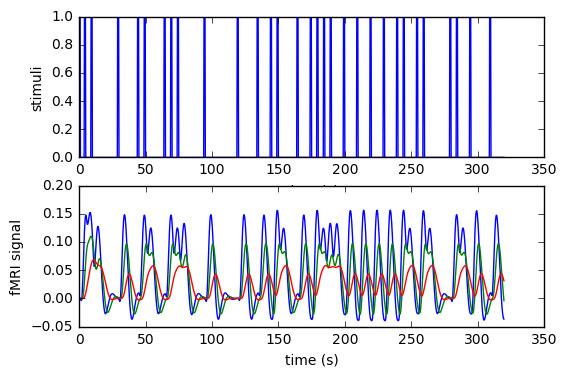

In [73]:
s=population.get_a_standard_subject()
m=CBI.configure_a_scanner()
u,y,x,h=m.quick_scan(s,return_x=True,return_h=True)
plt.subplot(211)
plt.plot(np.arange(m.n_time_point)*m.t_delta,u)
plt.xlabel('time (s)')
plt.ylabel('stimuli')
plt.subplot(212)
plt.plot(np.arange(m.n_time_point)*m.t_delta,y[:,0,:].transpose())
plt.xlabel('time (s)')
plt.ylabel('fMRI signal')

### Evaluate downsampling and interplation effect

In [74]:
# downsample fMRI signal
factor_downsample=mth.floor(2/m.t_delta)
t_axis_downsampled=np.arange(0,m.n_time_point,factor_downsample)
y_down_sampled=[y[n,:,0:m.n_time_point+1:factor_downsample] for n in range(m.n_region)]
y_down_sampled=np.asarray(y_down_sampled)

In [75]:
# fit interplate function
interplate_function_list=[]
for n in range(m.n_region):
    f =  interp1d(t_axis_downsampled, y_down_sampled[n,0,:], kind='cubic')
    interplate_function_list.append(f)

fine scale temporal interval = 0.25 s
down sampled to temporal interval = 2 s
full fMRI signal length = (1280,)
down sampled fMRI signal length = (160,)


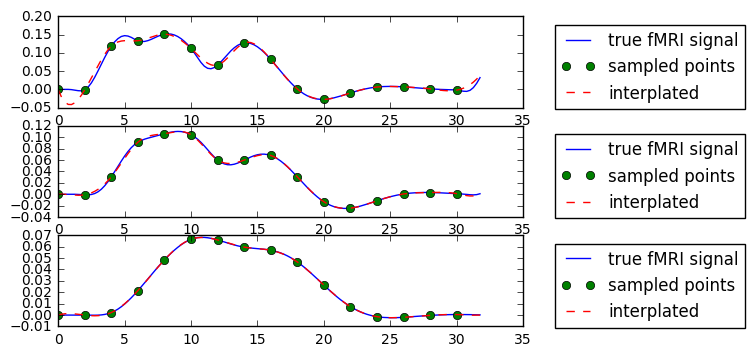

In [76]:
# visulize interplation results
n_vis=128
n_vis_downsampled=int(n_vis/factor_downsample)
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(0,n_vis)*m.t_delta,s.f_output[n,0,:n_vis],label="true fMRI signal")
    plt.plot(t_axis_downsampled[:n_vis_downsampled]*m.t_delta,y_down_sampled[n,0,:n_vis_downsampled].transpose(),'go',label="sampled points")
    plt.plot(np.arange(0,n_vis)*m.t_delta,interplate_function_list[n](np.arange(0,n_vis)),'r--',label="interplated")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
print('fine scale temporal interval = '+str(m.t_delta)+' s')
print('down sampled to temporal interval = 2 s')
print('full fMRI signal length = '+str(s.f_output[n,0,:].shape))
print('down sampled fMRI signal length = '+str(s.f_output[n,0,::int(2/m.t_delta)].shape))

### Data preparation

In [77]:
import data_helper
importlib.reload(data_helper)

<module 'data_helper' from '/Users/yuanwang/Google_Drive/projects/Gits/DCM-RNN/data_helper.py'>

In [78]:
# target u: [m.n_stimuli, n_recurrent_step]
# target x: [m.n_region, n_recurrent_step]
n_recurrent_step=8

dh=data_helper.get_a_data_helper()
dh.u=u[:]
dh.x=x[:]
dh.y=y[:]

dh.u_list=dh.cut2shape(dh.u,[m.n_stimuli, n_recurrent_step],n_recurrence=n_recurrent_step)
dh.x_list=dh.cut2shape(dh.x,[m.n_region, n_recurrent_step],n_recurrence=n_recurrent_step)
dh.y_list=dh.cut2shape(dh.y,[m.n_region, n_recurrent_step],n_recurrence=n_recurrent_step)
print('u_list has '+str(len(dh.u_list))+' segments, each of size '+str(dh.u_list[0].shape))
print('x_list has '+str(len(dh.x_list))+' segments, each of size '+str(dh.x_list[0].shape))
print('y_list has '+str(len(dh.x_list))+' segments, each of size '+str(dh.x_list[0].shape))

u_list has 160 segments, each of size (1, 8)
x_list has 160 segments, each of size (3, 8)
y_list has 160 segments, each of size (3, 8)


### Inference, start from u->x

In [97]:
# build DCM-RNN
ops.reset_default_graph()
import DCM_RNN
importlib.reload(DCM_RNN)
dr=DCM_RNN.create_a_dcm_rnn(m,n_recurrent_step=n_recurrent_step,learning_rate=0.001)

In [98]:
# training summary
acc_Wxx=1-dh.rMSE(dr.Wxx,s.Wxx)
acc_Wxxu=1-dh.rMSE(dr.Wxxu,s.Wxxu)
acc_Wxu=1-dh.rMSE(dr.Wxu,s.Wxu.reshape((m.n_region,1)))

loss_summary = tf.scalar_summary('fMRI_prediction_loss',dr.total_loss_y)
acc_Wxx_summary = tf.scalar_summary('acc_Wxx',acc_Wxx)
acc_Wxxu_summary = tf.scalar_summary('acc_Wxxu',acc_Wxxu)
acc_Wxu_summary = tf.scalar_summary('acc_Wxu',acc_Wxu)
opt_summary = tf.merge_summary([loss_summary, acc_Wxx_summary, acc_Wxxu_summary,acc_Wxu_summary])

summary_dir = os.path.abspath(os.path.join(os.path.curdir, "summary"))

# remove existing files
for the_file in os.listdir(summary_dir):
    file_path = os.path.join(summary_dir, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        #elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)

In [99]:
# open session and initilize
try:
    isess
except:
    isess = tf.InteractiveSession()
else:
    isess.close()
    isess = tf.InteractiveSession()

opt_init_all=tf.initialize_all_variables()
isess.run(opt_init_all)
# initilize matrices
#isess.run(dr.Wxx.assign(dr.Wxx_init))
#isess.run(dr.Wxxu.assign(dr.Wxxu_init))
#isess.run(dr.Wxu.assign(dr.Wxu_init))
# add summary
summary_writer = tf.train.SummaryWriter(summary_dir, isess.graph)

In [100]:
# load in utilities
rs=DCM_RNN.run(m,s,isess)

In [66]:
'''
# check forward pass, use the "true" parameters
Wxx=np.array([[-0.65,-0.2,0],[0.4,-0.4,-0.3],[0,0.2,-0.3]])*m.t_delta+np.eye(m.n_region,m.n_region,0)
Wxxu=np.array([[0.5,0,0.25],[0,0,0],[0,0,0.3]])*m.t_delta
Wxu=np.array([0.2,0,0]).reshape(3,1)*m.t_delta
# update matrices
dr.set_connection_matrices(isess, Wxx=Wxx, Wxxu=Wxxu, Wxu=Wxu)
'''

'\n# check forward pass, use the "true" parameters\nWxx=np.array([[-0.65,-0.2,0],[0.4,-0.4,-0.3],[0,0.2,-0.3]])*m.t_delta+np.eye(m.n_region,m.n_region,0)\nWxxu=np.array([[0.5,0,0.25],[0,0,0],[0,0,0.3]])*m.t_delta\nWxu=np.array([0.2,0,0]).reshape(3,1)*m.t_delta\n# update matrices\ndr.set_connection_matrices(isess, Wxx=Wxx, Wxxu=Wxxu, Wxu=Wxu)\n'

In [101]:
variables, key_order=rs.show_all_variable_value(dr,isess)
for key in key_order:
    print(key)
    print(variables[key])

Wxx
[[ 0.875  0.     0.   ]
 [ 0.     0.875  0.   ]
 [ 0.     0.     0.875]]
Wxxu
[[ 0.125  0.     0.   ]
 [ 0.     0.125  0.   ]
 [ 0.     0.     0.125]]
Wxu
[[ 0.125]
 [ 0.   ]
 [ 0.   ]]
alpha
{'alpha_r0': 0.31999999, 'alpha_r2': 0.31999999, 'alpha_r1': 0.31999999}
E0
{'E0_r1': 0.34, 'E0_r0': 0.34, 'E0_r2': 0.34}
k
{'k_r0': 0.64999998, 'k_r1': 0.64999998, 'k_r2': 0.64999998}
gamma
{'gamma_r1': 0.41, 'gamma_r0': 0.41, 'gamma_r2': 0.41}
tao
{'tao_r0': 0.98000002, 'tao_r2': 0.98000002, 'tao_r1': 0.98000002}
epsilon
{'epsilon_r0': 0.40000001, 'epsilon_r1': 0.40000001, 'epsilon_r2': 0.40000001}
V0
{'V0_r1': 1.0, 'V0_r2': 1.0, 'V0_r0': 1.0}
TE
{'TE_r0': 0.029999999, 'TE_r1': 0.029999999, 'TE_r2': 0.029999999}
r0
{'r0_r0': 25.0, 'r0_r2': 25.0, 'r0_r1': 25.0}
theta0
{'theta0_r1': 40.299999, 'theta0_r0': 40.299999, 'theta0_r2': 40.299999}


In [102]:

n_epoch=8
for epoch in range(n_epoch):
    x_tmp=[]
    loss_sum=0.
    gradient_list=[]
    x_feed=np.zeros((m.n_region,1),dtype=np.float32)
    x_feed[0]=0.0000001
    h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1)+0.000001 for _ in range(dr.n_region)]
    for i in range(0,len(dh.u_list)):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.rnn_u]=dh.u_list[i]
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
        
        
        grads_and_vars_tmp, tmp,x_feed,h_feed,loss_tmp, summaries, acc_Wxx_tmp,acc_Wxxu_tmp,acc_Wxu_tmp \
                                                    = isess.run([dr.train_step_y,
                                                    dr.x_state_predicted,
                                                    dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.total_loss_y,
                                                    opt_summary,
                                                    acc_Wxx,
                                                    acc_Wxxu,
                                                    acc_Wxu],\
                                                    feed_dict=feed_dict)
        loss_sum+=loss_tmp
    #print('epoch = '+str(epoch))
    '''
    dWxx=dr.Wxx.eval()-s.Wxx
    acc_Wxx=1-np.linalg.norm(dWxx)/np.linalg.norm(s.Wxx)
    dWxxu=dr.Wxxu.eval()-s.Wxxu
    acc_Wxxu=1-np.linalg.norm(dWxxu)/np.linalg.norm(s.Wxxu)
    dWxu=dr.Wxu.eval()-s.Wxu.reshape(m.n_region,1)
    acc_Wxu=1-np.linalg.norm(dWxu)/np.linalg.norm(s.Wxu)
    '''
    #print(summaries)
    summary_writer.add_summary(summaries, epoch)
    #print('epoch = '+str(epoch))

    print("epoch {}, loss {:g}, acc_Wxx {:g}, acc_Wxxu {:g}, acc_Wxu {:g}"\
          .format(epoch, loss_sum, acc_Wxx_tmp, acc_Wxxu_tmp, acc_Wxu_tmp))
    

epoch 0, loss 11.9035, acc_Wxx 0.897289, acc_Wxxu 0.0641707, acc_Wxu -0.499097
epoch 1, loss 11.9228, acc_Wxx 0.897223, acc_Wxxu 0.0641707, acc_Wxu -0.498211
epoch 2, loss 11.9424, acc_Wxx 0.897156, acc_Wxxu 0.0641705, acc_Wxu -0.497342
epoch 3, loss 11.9623, acc_Wxx 0.89709, acc_Wxxu 0.0641704, acc_Wxu -0.49649


KeyboardInterrupt: 

In [60]:
for key, value in feed_dict.items():
    print(key)
    print(type(value))

Tensor("Const:0", shape=(4, 1), dtype=float32)
<class 'numpy.ndarray'>
Tensor("Const_1:0", shape=(4, 1), dtype=float32)
<class 'numpy.ndarray'>
Tensor("zeros:0", shape=(3, 1), dtype=float32)
<class 'numpy.ndarray'>
Tensor("y_true_input_as_array:0", shape=(3, 8), dtype=float32)
<class 'numpy.ndarray'>
Tensor("rnn_u:0", shape=(1, 8), dtype=float32)
<class 'numpy.ndarray'>
Tensor("Const_2:0", shape=(4, 1), dtype=float32)
<class 'numpy.ndarray'>


In [69]:
variables, key_order=rs.show_all_variable_value(dr,isess)
for key in key_order:
    print(key)
    print(variables[key])

Wxx
[[  8.93960774e-01  -4.57203278e-04  -1.01624965e-03]
 [ -7.11534452e-03   8.75268281e-01   4.86589997e-04]
 [ -9.14381165e-03   2.70282791e-04   8.75578761e-01]]
Wxxu
[[  1.25959218e-01  -3.21583611e-05  -7.09239685e-05]
 [ -1.32105939e-04   1.25029907e-01   3.71024871e-05]
 [ -6.40921528e-04   2.45839692e-05   1.25046939e-01]]
Wxu
[[ 0.12553839]
 [ 0.00424416]
 [-0.00323766]]
alpha
{'alpha_r0': 0.31999999, 'alpha_r2': 0.31999999, 'alpha_r1': 0.31999999}
E0
{'E0_r1': 0.34, 'E0_r0': 0.34, 'E0_r2': 0.34}
k
{'k_r0': 0.64999998, 'k_r1': 0.64999998, 'k_r2': 0.64999998}
gamma
{'gamma_r1': 0.41, 'gamma_r0': 0.41, 'gamma_r2': 0.41}
tao
{'tao_r0': 0.98000002, 'tao_r2': 0.98000002, 'tao_r1': 0.98000002}
epsilon
{'epsilon_r0': 0.40000001, 'epsilon_r1': 0.40000001, 'epsilon_r2': 0.40000001}
V0
{'V0_r1': 1.0, 'V0_r2': 1.0, 'V0_r0': 1.0}
TE
{'TE_r0': 0.029999999, 'TE_r1': 0.029999999, 'TE_r2': 0.029999999}
r0
{'r0_r0': 25.0, 'r0_r2': 25.0, 'r0_r1': 25.0}
theta0
{'theta0_r1': 40.299999, 'theta0_

In [115]:
# run forward pass
x_predicted=rs.forward_pass_x(dr,dh,isess)
h_predicted=rs.forward_pass_h(dr,dh,isess)
y_predicted=rs.forward_pass_y(dr,dh,isess)

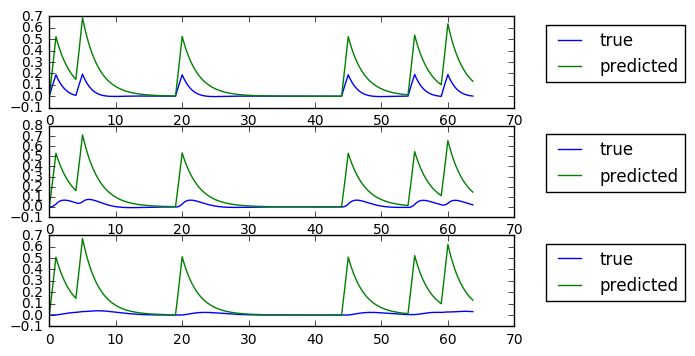

In [116]:
# visulize pridicted x_state and true x_state (before training)
n_monitor=256
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,x[n,0,:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,x_predicted[n,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

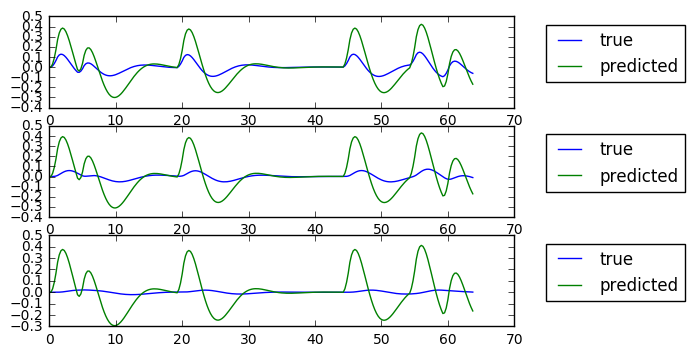

In [119]:
# visulize pridicted h_state and true h_state (before training)
n_monitor=256
i_h_state=0
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,h[n,i_h_state,0:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,h_predicted[n][i_h_state,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

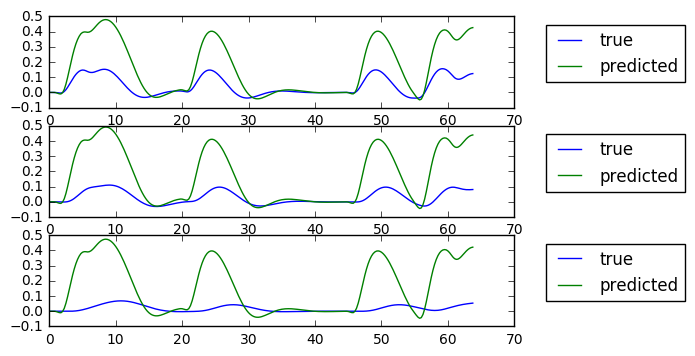

In [120]:
# y_predicted=rs.forward_pass_y(dr,dh,isess)
# visulize pridicted y_predicted and true y 
n_monitor=256
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,y[n,0,:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,y_predicted[n,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [789]:
# run training by minimizing y error
n_epoch=256
for epoch in range(n_epoch):
    x_tmp=[]
    loss_sum=0
    gradient_list=[]
    x_feed=np.zeros((m.n_region,1))
    x_feed[0]=0.0000001
    h_feed=[np.array([0,1,1,1],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]
    for i in range(0,len(dh.u_list)):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.rnn_u]=dh.u_list[i]
        feed_dict[dr.rnn_x]=dh.x_list[i]
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
        
        
        _, tmp,x_feed,h_feed,loss_tmp, summaries, acc_Wxx_tmp,acc_Wxxu_tmp,acc_Wxu_tmp \
                                                    = isess.run([dr.train_step_y,
                                                    dr.x_state_predicted,
                                                    dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.total_loss_y,
                                                    opt_summary,
                                                    acc_Wxx,
                                                    acc_Wxxu,
                                                    acc_Wxu],\
                                                    feed_dict=feed_dict)
                                                
     
    #print(summaries)
    summary_writer.add_summary(summaries, epoch)
    #print('epoch = '+str(epoch))


    
    print("epoch {}, loss {:g}, acc_Wxx {:g}, acc_Wxxu {:g}, acc_Wxu {:g}"\
          .format(epoch, loss_sum, acc_Wxx_tmp, acc_Wxxu_tmp, acc_Wxu_tmp))
    '''
    print('%%%%%%%%%%%%%% '+ str(epoch)+" %%%%%%%%%%%%")
    print("loss "+ "{:.6f}".format(loss_sum))
    print('rMSE')
    print(np.linalg.norm(dWxx)/np.linalg.norm(s.Wxx))
    '''
    

epoch 0, loss 0, acc_Wxx nan, acc_Wxxu nan, acc_Wxu nan


KeyboardInterrupt: 

In [801]:
variables = tf.get_collection(tf.GraphKeys.VARIABLES, scope='rnn_cell')

dr.Wxx.eval()

array([[ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan]], dtype=float32)

In [730]:
# run training 
n_epoch=256
for epoch in range(n_epoch):
    x_tmp=[]
    loss_sum=0
    gradient_list=[]
    training_state=np.zeros((m.n_region,1))
    training_state[0]=0.0000001
    for i in range(0,len(dh.u_list)):

        _, tmp,training_state,loss_tmp, summaries, acc_Wxx_tmp,acc_Wxxu_tmp,acc_Wxu_tmp \
                                                    = isess.run([dr.train_step,
                                                    dr.x_state_predicted,
                                                    dr.x_state_final,
                                                    dr.total_loss,
                                                    opt_summary,
                                                    acc_Wxx,
                                                    acc_Wxxu,
                                                    acc_Wxu],\
                                       feed_dict={dr.rnn_u:dh.u_list[i], \
                                                  dr.rnn_x:dh.x_list[i],\
                                                  dr.x_state_initial:training_state})
     
    #print(summaries)
    summary_writer.add_summary(summaries, epoch)
    #print('epoch = '+str(epoch))


    
    print("epoch {}, loss {:g}, acc_Wxx {:g}, acc_Wxxu {:g}, acc_Wxu {:g}"\
          .format(epoch, loss_sum, acc_Wxx_tmp, acc_Wxxu_tmp, acc_Wxu_tmp))
    '''
    print('%%%%%%%%%%%%%% '+ str(epoch)+" %%%%%%%%%%%%")
    print("loss i"+ "{:.6f}".format(loss_sum))
    print('rMSE')
    print(np.linalg.norm(dWxx)/np.linalg.norm(s.Wxx))
    '''
    

AttributeError: 'create_a_dcm_rnn' object has no attribute 'train_step'

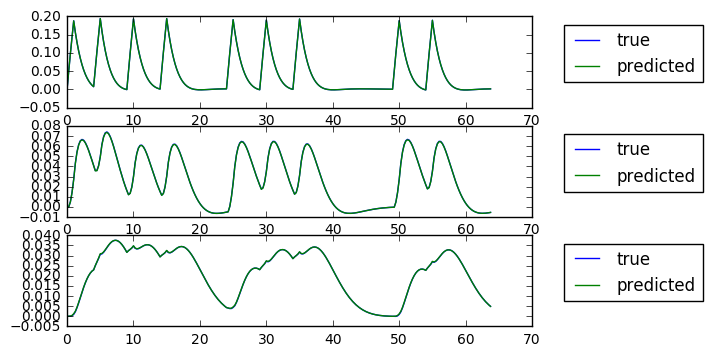

In [436]:
# show prediction accuracy after training
x_predicted=rs.forward_pass(dr,dh,isess)
n_monitor=256
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,x[n,0,:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,x_predicted[n,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [437]:
print(dr.Wxx.eval())
print(s.Wxx)

[[  8.37508738e-01  -4.99544814e-02   4.28412459e-05]
 [  9.98858660e-02   8.99913967e-01  -7.50174373e-02]
 [  5.24617753e-05   5.00212200e-02   9.24988508e-01]]
[[ 0.8375 -0.05    0.    ]
 [ 0.1     0.9    -0.075 ]
 [ 0.      0.05    0.925 ]]


In [438]:
print(dr.Wxxu.eval())
print(s.Wxxu)

[[  1.24835826e-01  -1.18896656e-03   6.38780296e-02]
 [ -1.61269272e-04   6.87352076e-05   9.57742959e-05]
 [  1.59951509e-04   8.56118917e-04   7.38826916e-02]]
[[ 0.125   0.      0.0625]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.075 ]]


In [439]:
print(dr.Wxu.eval())
print(s.Wxu)

[[  4.99444790e-02]
 [ -6.62461971e-05]
 [  6.20318315e-05]]
[ 0.05  0.    0.  ]


##### backup sections

In [ ]:
# run training (backup)
n_epoch=128
for epoch in range(n_epoch):
    x_tmp=[]
    loss_sum=0
    gradient_list=[]
    training_state=np.zeros((m.n_region,1))
    training_state[0]=0.0000001
    for i in range(0,len(dh.u_list)):

        _, tmp,training_state,loss_tmp = isess.run([dr.train_step, dr.x_state_predicted,dr.x_state_final,dr.total_loss],\
                                       feed_dict={dr.rnn_u:dh.u_list[i], \
                                                  dr.rnn_x:dh.x_list[i],\
                                                  dr.x_state_initial:training_state})
        tmp=np.asarray(tmp)
        tmp=tmp[:,:,0]
        x_tmp.append(tmp)
        loss_sum+=loss_tmp
        
    dWxx=dr.Wxx.eval()-s.Wxx
    acc_Wxx=1-np.linalg.norm(dWxx)/np.linalg.norm(s.Wxx)
    dWxxu=dr.Wxxu.eval()-s.Wxxu
    acc_Wxxu=1-np.linalg.norm(dWxxu)/np.linalg.norm(s.Wxxu)
    dWxu=dr.Wxu.eval()-s.Wxu.reshape(m.n_region,1)
    acc_Wxu=1-np.linalg.norm(dWxu)/np.linalg.norm(s.Wxu)
    
    # training summary
    loss_summary = tf.scalar_summary('loss',loss_sum)
    acc_Wxx_summary = tf.scalar_summary('acc_Wxx',acc_Wxx)
    acc_Wxxu_summary = tf.scalar_summary('acc_Wxxu',acc_Wxxu)
    acc_Wxu_summary = tf.scalar_summary('acc_Wxu',acc_Wxu)
    train_summary = tf.merge_summary([loss_summary, acc_Wxx_summary, acc_Wxxu_summary,acc_Wxu_summary])
    
    summary_writer.add_summary(all_summaries, step)




    
    print("epoch {}, loss {:g}, acc_Wxx {:g}, acc_Wxxu {:g}, acc_Wxu {:g}"\
          .format(epoch, loss_sum, acc_Wxx, acc_Wxxu, acc_Wxu))
    '''
    print('%%%%%%%%%%%%%% '+ str(epoch)+" %%%%%%%%%%%%")
    print("loss "+ "{:.6f}".format(loss_sum))
    print('rMSE')
    print(np.linalg.norm(dWxx)/np.linalg.norm(s.Wxx))
    '''
    

In [20]:
i=0
print(training_state)
#tmp=training_state
#training_state=tmp
training_state=np.zeros((m.n_region,1))
feed_dict={dr.rnn_u:dh.u_list[i],  dr.rnn_x:dh.x_list[i],dr.x_state_initial:training_state}

x_state_predicted=isess.run(dr.x_state_predicted,feed_dict=feed_dict)
rnn_x_as_list=isess.run(dr.rnn_x_as_list,feed_dict=feed_dict)
loss=isess.run(dr.loss,feed_dict=feed_dict)
total_loss=isess.run(dr.total_loss,feed_dict=feed_dict)

for i in range(dr.n_recurrent_step):
    print(x_state_predicted[i])
    print(rnn_x_as_list[i])
    print(loss[i])
print(total_loss)

print(np.mean(np.sqrt(loss)))


[[-0.00166183]
 [-0.0012393 ]
 [-0.00021845]]
[[ 0.]
 [ 0.]
 [ 0.]]
[[ 0.]
 [ 0.]
 [ 0.]]
0.0
[[ 0.04398323]
 [-0.01650667]
 [ 0.01000542]]
[[ 0.05]
 [ 0.  ]
 [ 0.  ]]
0.00013626
[[ 0.07833804]
 [-0.01296492]
 [ 0.00659185]]
[[ 0.1  ]
 [ 0.005]
 [ 0.   ]]
0.000278477
[[ 0.10720271]
 [-0.00428446]
 [ 0.01328812]]
[[ 0.14974999]
 [ 0.014375  ]
 [ 0.00025   ]]
0.000776147
0.014055
0.014055


In [54]:
# Create an optimizer.
opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)

In [56]:
# Compute the gradients for a list of variables.
grads_and_vars = opt.compute_gradients(dr.total_loss, [dr.Wxx])


Exception ignored in: <bound method BaseSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x10e5f1ba8>>
Traceback (most recent call last):
  File "/Users/yuanwang/anaconda/envs/tensorFlow/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 522, in __del__
    self.close()
  File "/Users/yuanwang/anaconda/envs/tensorFlow/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1262, in close
    self._default_session.__exit__(None, None, None)
  File "/Users/yuanwang/anaconda/envs/tensorFlow/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/Users/yuanwang/anaconda/envs/tensorFlow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3536, in get_controller
    % type(default))
AssertionError: Nesting violated for default stack of <class 'weakref'> objects
Exception ignored in: <bound method BaseSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x1

In [57]:
grads_and_vars

[(<tf.Tensor 'gradients/AddN_2:0' shape=(3, 3) dtype=float32>,
  <tensorflow.python.ops.variables.Variable at 0x11048af28>)]

In [58]:
# Ask the optimizer to apply the capped gradients.
opt_apply_gradient=opt.apply_gradients(grads_and_vars)

In [36]:
# Create an optimizer.
opt = tf.GradientDescentOptimizer(learning_rate=0.1)

# Compute the gradients for a list of variables.
grads_and_vars = opt.compute_gradients(loss, <list of variables>)

# grads_and_vars is a list of tuples (gradient, variable).  Do whatever you
# need to the 'gradient' part, for example cap them, etc.
capped_grads_and_vars = [(MyCapper(gv[0]), gv[1]) for gv in grads_and_vars]

# Ask the optimizer to apply the capped gradients.
opt.apply_gradients(capped_grads_and_vars)

SyntaxError: invalid syntax (<ipython-input-36-fe010f4ba333>, line 5)